In [1]:
#1) Import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import ee
import geemap.foliumap as geemap
import geopandas as gpd
from datetime import datetime
import ipywidgets as widgets
import seaborn as sns


In [2]:
from constants import   STUDY_BOUNDARY_PATH


In [3]:
shapefile_path = STUDY_BOUNDARY_PATH
study_boundary = gpd.read_file(shapefile_path)

# Import Landsat8 OLI

https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#terms-of-use

 Landsat-8 image courtesy of the U.S. Geological Survey

In [4]:
# Initialize the Earth Engine library
#ee.Authenticate()
ee.Initialize()

In [5]:
# Define the collection
collection = "LANDSAT/LC08/C02/T1_L2"

In [6]:
# Load the study area
ee_boundary = geemap.geopandas_to_ee(study_boundary)


In [7]:
aoi = ee_boundary.geometry()

In [8]:
# Define the Image Collection
image_collection = ee.ImageCollection(collection) \
    .filterBounds(aoi) \
    .sort('system:time_start', False)

In [9]:
# Get  ~ 2 1/2 years of images
recent_images = image_collection.limit(100)

In [10]:
# Get the dates of the images
dates = recent_images.aggregate_array('system:time_start').getInfo()
# Convert the timestamps to readable dates
dates = [datetime.fromtimestamp(date/1000).strftime('%Y-%m-%d') for date in dates]
# Sort the list of unique dates in descending order
dates = sorted(list(set(dates)), reverse=True)

# Print the unique dates


# Print the unique dates
print("Dates of the four most recent images:", dates)

Dates of the four most recent images: ['2023-06-10', '2023-05-25', '2023-05-09', '2023-04-07', '2023-03-22', '2023-03-06', '2023-02-18', '2023-02-02', '2023-01-17', '2023-01-01', '2022-12-16', '2022-11-30', '2022-11-14', '2022-10-29', '2022-10-13', '2022-09-27', '2022-08-26', '2022-08-10', '2022-07-25', '2022-07-09', '2022-06-23', '2022-06-07', '2022-05-22', '2022-05-06', '2022-04-20', '2022-04-04', '2022-03-19', '2022-03-03', '2022-02-15', '2022-01-30', '2022-01-14', '2021-12-29', '2021-12-13', '2021-11-27', '2021-11-11', '2021-10-26', '2021-10-10', '2021-09-24', '2021-09-08', '2021-08-23', '2021-08-07', '2021-07-22', '2021-07-06', '2021-06-20', '2021-06-04', '2021-05-19', '2021-05-03', '2021-04-17', '2021-04-01', '2021-03-16', '2021-02-28', '2021-02-12']


In [12]:
# Define a function to apply scaling and offset
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    image = image.addBands(optical_bands, None, True)
    image = image.addBands(thermal_bands, None, True)
    return image


https://calekochenour.github.io/remote-sensing-textbook/03-beginner/chapter13-data-quality-bitmasks.html


In [13]:
# Define function to return QA bands

def extract_qa_bits(qa_band, start_bit, end_bit, band_name):
    """
    Extracts QA values from an image
    :param qa_band: Single-band image of the QA layer
    :type qa_band: ee.Image
    :param start_bit: Starting bit
    :type start_bit: Integer
    :param end_bit: Ending bit
    :type end_bit: Integer
    :param band_name: New name for the band
    :type band_name: String
    :return: Image with extracted QA values
    :rtype: ee.Image
    """
    # Initialize QA bit string/pattern to check QA band against
    qa_bits = 0
    # Add each specified QA bit flag value/string/pattern to the QA bits to check/extract
    for bit in range(start_bit, end_bit + 1):
        qa_bits += pow(2, bit)  # Same as qa_bits += (1 << bit)
    # Return a single band image of the extracted QA bit values
    return qa_band.select([0], [band_name]).bitwiseAnd(qa_bits).rightShift(start_bit)


In [15]:
# Define a function to calculate SPM from Novoa et al.(2017) based on Nechad et al. (2010) NIR (recalibrated) model

def novoa_et_al_spm(image):
    # extract the cloud and water masks
    qa_band = ee.Image(image).select('QA_PIXEL')
    cloudMask = extract_qa_bits(qa_band, 8, 9, "cloud").neq(3)  # different than 3 to remove clouds
    waterMask = extract_qa_bits(qa_band, 7, 7, "water").eq(1)  # equals 1 to keep water

    # apply the masks to the image
    image = image.updateMask(cloudMask).updateMask(waterMask)
    image =  apply_scale_factors(image)

# Select the NIR band (B5 for Landsat 8 OLI)
    nir = image.select('SR_B5')
# Apply the Nechad et al. (2010) NIR (recalibrated) model
    spm = image.expression(
        "4302 * (nir / (1 - nir / 0.2115))",
        {'nir': nir}
    )
    # Set negative SPM values to zero
    spm = spm.where(spm.lt(0), 0)
    image = image.addBands(spm.select([0], ['spm']))


    return image

In [17]:
def extract_data_spm(image):
    stats = image.reduceRegion(ee.Reducer.mean(), aoi, 30)
    valid_pixels = image.select('spm').unmask().neq(0)  # create a mask of valid pixels
    valid_area = valid_pixels.multiply(ee.Image.pixelArea()).reduceRegion(ee.Reducer.sum(), aoi, 30)  # calculate the area of valid pixels
    return image.set('date', image.date().format()).set(stats).set('Area', valid_area)


In [19]:
viridis_palette = [
    '440154', '440256', '450457', '450559', '46075a', '46085c', '460a5d', '460b5e', '470d60', 
    '470e61', '471063', '471164', '471365', '481467', '481668', '481769', '48186a', '481a6c', 
    '481b6d', '481c6e', '481d6f', '481f70', '482071', '482173', '482374', '482475', '482576', 
    '482677', '482878', '482979', '472a7a', '472c7a', '472d7b', '472e7c', '472f7d', '46307e', 
    '46327e', '46337f', '463480', '453581', '453781', '453882', '443983', '443a83', '443b84', 
    '433d84', '433e85', '423f85', '424086', '424186', '414287', '414487', '404588', '404688', 
    '3f4788', '3f4889', '3e4989', '3e4a89', '3e4c8a', '3d4d8a', '3d4e8a', '3c4f8a', '3c508b', 
    '3b518b', '3b528b', '3a538b', '3a548c', '39558c', '39568c', '38588c', '38598c', '375a8c', 
    '375b8d', '365c8d', '365d8d', '355e8d', '355f8d', '34608d', '34618d', '33628d', '33638d', 
    '32648e', '32658e', '31668e', '31678e', '30688e', '30698e', '2f6a8e', '2f6b8e', '2e6c8e', 
    '2e6d8e', '2d6e8e', '2d6f8e', '2c708e', '2c718e', '2b728e', '2b738e', '2a748e', '2a758e', 
    '29768e', '29778e', '28788e', '28798e', '277a8e', '277b8e', '267c8e', '267d8e', '257e8e', 
    '257f8e', '24808e', '24818e', '23828e', '23828e', '22838e', '22848e', '21858e', '21868e', 
    '20878e', '20888e', '1f898e', '1f8a8d', '1e8b8d', '1e8c8d', '1d8d8d', '1d8e8d', '1c8f8d', 
    '1c8f8d', '1b908c', '1b918c', '1a928c', '1a938b', '19948b', '19958b', '18968a', '18978a', 
    '17988a', '179989', '169a89', '169b88', '159c88', '159d87', '149e87', '149f86', '13a086', 
    '13a185', '12a285', '12a384', '11a483', '11a583', '10a682', '10a781', '0fa881', '0fa980', 
    '0eaa7f', '0eab7e', '0dac7e', '0dad7d', '0cae7c', '0caf7b', '0bb07a', '0bb179', '0ab278', 
    '0ab377', '09b476', '09b575', '08b674', '08b773', '07b872', '07b971', '06ba70', '06bb6f', 
    '05bc6e', '05bd6d', '04be6c', '04bf6b', '03c06a', '03c169', '02c268', '02c367', '01c466', 
    '01c565', '00c664'
]

In [23]:
spm_params= {
  'bands': ['spm'],
  'min': 0,
  'max': 50,
  'palette': viridis_palette
}
spm_map = geemap.Map()
spm_map.add_basemap(basemap='TERRAIN')

In [24]:
processed_collection_spm = ee.ImageCollection([])


# Loop through the dates and get the imagery.
for date in dates:
    start_date = ee.Date(date)
    end_date = start_date.advance(1, 'day')

   # Filter the image collection by date and area
    image = ee.ImageCollection(collection) \
        .filterDate(start_date, end_date) \
        .filterBounds(aoi) \
        .first()  # get the first image that matches the filters

    if image:          # check if image exists
        
        clipped_image = image.clip(aoi)  # Clip the image to the study boundary
        processed_image_spm = novoa_et_al_spm(clipped_image)  # process the image
        spm_map.addLayer(processed_image_spm, spm_params, date, shown = False)  # add the image to the map
        processed_collection_spm = processed_collection_spm.merge(processed_image_spm)  # add the image to the processed collection

    else:
        print(f"No image found for date {date}")


# Map the extract_data function over the processed_collection_spmn.
extract__collection_spm = processed_collection_spm.map(extract_data_spm)

# Reduce the processed collection to a list of dates, spm values, and area.
data_spm = extract__collection_spm.reduceColumns(ee.Reducer.toList(3), ['date', 'spm', 'Area']).get('list').getInfo()



In [25]:
# Set the map to focus on the study area
spm_map.centerObject(aoi, zoom=11)
spm_map.add_colorbar_branca(vis_params= spm_params, colors = viridis_palette ,vmin =  0, vmax = 50, label = 'g/m³')
spm_map

In [28]:
df_spm = pd.DataFrame(data_spm, columns=['date', 'spm', 'Area'])
df_spm['date'] = pd.to_datetime(df_spm['date'])
df_spm['Area'] = df_spm['Area'].apply(lambda x: x['spm'])
df_spm['spm_norm'] = df_spm['spm'] / df_spm['Area']


In [29]:
df_spm = df_spm[df_spm['date'] != '2022-05-22 18:28:16']  # Keep only the rows where 'date' is not '2022-05-22'


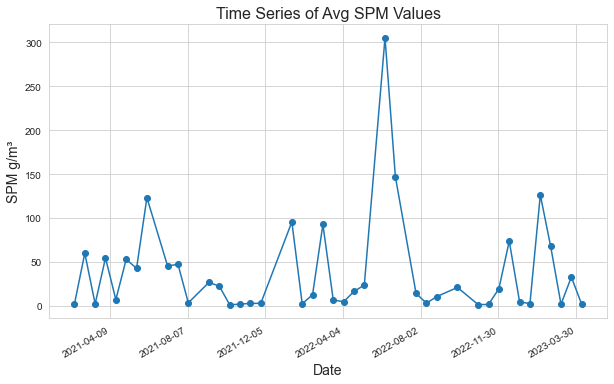

In [32]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_spm['date'], df_spm['spm'], marker='o', linestyle='-')

# Format the x-axis to display the dates in a more readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))  # adjust the interval as needed
plt.gcf().autofmt_xdate()  # rotate the x labels

# Add a title and labels to the axes
plt.title('Time Series of Avg SPM Values', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('SPM g/m³', fontsize=14)
# Show the plot
plt.show()

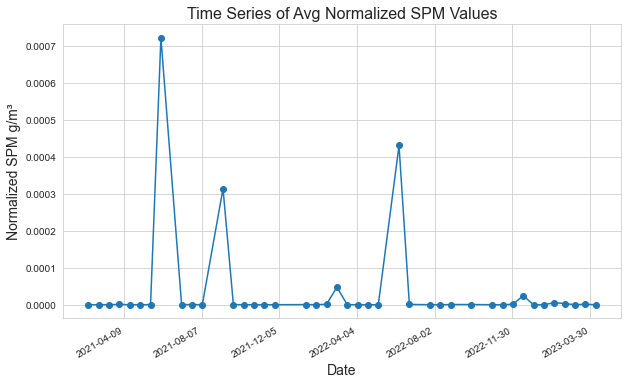

In [33]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_spm['date'], df_spm['spm_norm'], marker='o', linestyle='-')

# Format the x-axis to display the dates in a more readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))  # adjust the interval as needed
plt.gcf().autofmt_xdate()  # rotate the x labels

# Add a title and labels to the axes
plt.title('Time Series of Avg Normalized SPM Values', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Normalized SPM g/m³', fontsize=14)
# Show the plot
plt.show()